In [42]:
#!pip uninstall -y tensorflow tensorflow-intel tensorflow-gpu

In [43]:
#!pip uninstall -y tensorflow-io-gcs-filesystem 0.31.0
#!pip uninstall -y tensorflow-estimator         2.13.0

In [44]:
#!pip cache purge

In [45]:
#!pip install --upgrade pip

In [46]:
#!pip install tensorflow==2.15.0 --upgrade

In [47]:
#!pip list | findstr tensorflow

In [48]:
# 📚 IMPORTAR LIBRERÍAS PRINCIPALES
import tensorflow as tf
import os

# ⚙️ CONFIGURAR USO DE GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar solo la primera GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU configurada correctamente.")
    except RuntimeError as e:
        print(e)
else:
    print("❌ No se encontró GPU. Usando CPU.")


❌ No se encontró GPU. Usando CPU.


In [49]:
# 📚 Librerías Necesarias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib

# ✅ Parámetros Globales optimizados para CPU
IMG_SIZE = (128, 128)  # Mantén el tamaño si el rendimiento es aceptable
BATCH_SIZE = 16        # Reduce el tamaño del lote para evitar sobrecarga en CPU
EPOCHS = 30            # Menor cantidad de épocas para evitar tiempos de entrenamiento excesivos
COLOR_MODE = 'grayscale'  # Imágenes en escala de grises
AUTOTUNE = tf.data.AUTOTUNE

In [50]:
# ✅ Rutas de Datos
ruta_train_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# ✅ Cargar Datos
df_train = pd.read_csv(ruta_train_csv)
df_test = pd.read_csv(ruta_test_csv)

# ✅ Preprocesamiento de Imágenes optimizado para CPU
def cargar_datos(df, ruta_img, es_entrenamiento=True):
    ids = df['id'].values
    labels = df['clip_count'].values if 'clip_count' in df.columns else None
    
    def preprocesar_imagen(id, label=None):
        img_path = tf.strings.join([ruta_img, "/clips-", tf.strings.as_string(id), ".png"])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return (img, tf.cast(label, tf.float32)) if label is not None else img
    
    dataset = tf.data.Dataset.from_tensor_slices((ids, labels) if es_entrenamiento else ids)
    dataset = dataset.map(
        lambda id, label=None: preprocesar_imagen(id, label),
        num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.cache()  # Evita recargar imágenes en cada época
    if es_entrenamiento:
        dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# ✅ Crear Datasets
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
dataset_train = cargar_datos(df_train, ruta_train_img, es_entrenamiento=True)
dataset_val = cargar_datos(df_val, ruta_train_img, es_entrenamiento=True)
dataset_test = cargar_datos(df_test, ruta_test_img, es_entrenamiento=False)

In [51]:
# ✅ Definir el Modelo CNN optimizado para CPU
def crear_modelo():
    modelo = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),  # Reduce la cantidad de neuronas
        Dropout(0.5),
        Dense(1, activation='linear')  # Salida de regresión
    ])
    
    modelo.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return modelo

# ✅ Crear Modelo
modelo = crear_modelo()
modelo.summary()

C:\Users\mikel\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,089 (12.61 MB)

 Trainable params: 3,304,641 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 178s 233ms/step - loss: 280.4232 - rmse: 15.9230 - val_loss: 244.7247 - val_rmse: 15.6437 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 228s 304ms/step - loss: 132.2562 - rmse: 11.4985 - val_loss: 370.3871 - val_rmse: 19.2454 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 232s 309ms/step - loss: 109.8862 - rmse: 10.4807 - val_loss: 487.8449 - val_rmse: 22.0872 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 223s 297ms/step - loss: 111.2292 - rmse: 10.5449 - val_loss: 41.3170 - val_rmse: 6.4278 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 229s 305ms/step - loss: 112.1038 - rmse: 10.5860 - val_loss: 16.3008 - val_rmse: 4.0374 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 221s 294ms/step - loss: 108.7835 - rmse: 10.4284 - val_loss: 39.9709 - val_rmse: 6.3223 - learning_rate: 0.0010
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 230s 307ms/step - loss: 101.5463 - rmse: 1

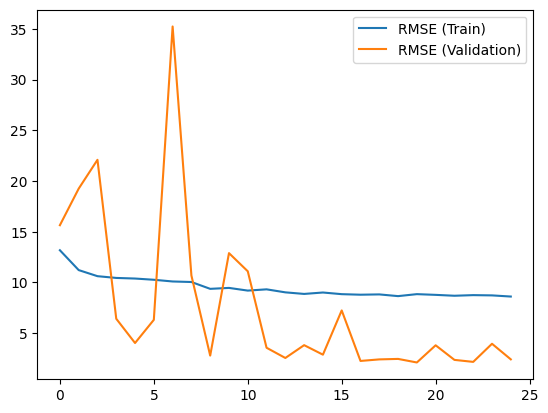

In [52]:
# ✅ Callbacks optimizados
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

# ✅ Entrenar Modelo
historial = modelo.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

# ✅ Graficar Métricas
plt.plot(historial.history['rmse'], label='RMSE (Train)')
plt.plot(historial.history['val_rmse'], label='RMSE (Validation)')
plt.legend()
plt.show()

In [53]:
# ✅ Evaluación
train_loss, train_rmse = modelo.evaluate(dataset_train)
val_loss, val_rmse = modelo.evaluate(dataset_val)
print(f"🔹 RMSE (Train): {train_rmse:.2f}")
print(f"🔹 RMSE (Validation): {val_rmse:.2f}")

# ✅ Predicciones
predicciones = modelo.predict(dataset_test).flatten()
df_test['clip_count'] = np.round(predicciones).astype(int)

# ✅ Guardar Resultados
df_test[['id', 'clip_count']].to_csv('submission_p.csv', index=False)
print("✅ Archivo 'submission_p.csv' generado correctamente.")

750/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - loss: 3.5887 - rmse: 1.8941
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 4.5850 - rmse: 2.1409
🔹 RMSE (Train): 1.88
🔹 RMSE (Validation): 2.12
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step
✅ Archivo 'submission_p.csv' generado correctamente.


In [54]:
# ✅ Guardar el Modelo en la Carpeta 'modelo_final'
ruta_modelo_completo = os.path.join('modelo_final', 'modelo_clip_count_p.h5')
modelo.save(ruta_modelo_completo)
print(f"✅ Modelo guardado en '{ruta_modelo_completo}'")

✅ Modelo guardado en 'modelo_final\modelo_clip_count_p.h5'
